# Project 1: Classify Images of Road Traffic Signs

### Objective
-  Identify and classify images of road traffic signs to enhance navigation systems and improve road safety

### **Dataset**

Source: Belgium Traffic Sign Classification Benchmark, German TSC dataset

Input variables:

Output variable (desired target):

# Table of Contents
* 1. Import Libraries
* 2. Process the dataset
* 3. Exploratory Data Analysis (EDA)
  - 3.1 Visualise sample images according to shape and type
  - 3.2 Data Distribution
* 4. Data Splitting
* 5. Data Modelling
  - 5.1 Baseline Model: MLP NN
    - Model 1.1: Shape classification using MLP NN
    - Model 1.2: Type classification using MLP NN
    - Model 1.3: Combined Model using MLP NN
  - 5.2 Advanced Model: CNN VGG
    - Model 2.1: Shape classification using CNN
    - Model 2.2: Type
classification using CNN
  - Data Augmentation
* 6. Testing the model
* 7. Conclusion
* 8. Reference

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import confusion_matrix, f1_score

# show better graph
%matplotlib inline

In [2]:
from google.colab import drive
drive .mount('/content/drive')

Mounted at /content/drive


#### Connect to the dataset file from google drive

In [3]:
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset.zip .
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset_testing.zip .

# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset.zip .
# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset_testing.zip .

Unzip the dataset

In [4]:
import zipfile
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('trafficsigns_dataset_testing.zip', 'r') as zip_ref_test:
    zip_ref_test.extractall('./')

## 2. Process the dataset
Collect Image Files
- Function to traverse directories recursively and collect image files from the offered dataset and additional dataset for testing

In [5]:
def collect_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

In [6]:
all_image_files = collect_image_files('./trafficsigns_dataset')
all_test_image = collect_image_files('./trafficsigns_dataset_testing')

Create a DataFrame with image file paths in a column named 'image_path'

In [7]:
df = pd.DataFrame({'image_path': all_image_files})
df_test = pd.DataFrame({'image_path': all_test_image})

To encode the traffic sign shapes and types

In [8]:
trafficsigns_shapes = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
trafficsigns_types = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry': 4, 'noparking': 5,
                      'roundabout':6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10,
                      'crossing': 11,  'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

This project involves **multi-class image classification** and features traffic signs categorised into 5 shape classes and 16 type classes, with each image being classified into one of these categories

In [9]:
def assign_class_label(image_path):
    # Split the image path by '/'
    parts = image_path.split('/')

    # Extract shape and type from the parts
    shape = parts[-3]
    trafficsign_type = parts[-2]

    # Map shape and type to corresponding class labels using the dictionaries
    shape_label = trafficsigns_shapes.get(shape, -1)  # -1 if shape not found in dictionary
    type_label = trafficsigns_types.get(trafficsign_type, -1)  # -1 if type not found in dictionary

    # Return a tuple of shape label and type label
    return (shape_label, type_label)


- Get the dataframe with image_path, shape_label and type_label

In [10]:
df['shape_label'], df['type_label'] = zip(*df['image_path'].apply(assign_class_label))
df_test['shape_label'], df_test['type_label'] = zip(*df_test['image_path'].apply(assign_class_label))

In [11]:
print(f"Shape of offered dataset: {df.shape}.\n Shape of additional dataset: {df_test.shape}")

Shape of offered dataset: (3699, 3).
 Shape of additional dataset: (2234, 3)


In [12]:
df.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset/round/speed/01511_00000...,2,7
1,./trafficsigns_dataset/round/speed/01112_00001...,2,7
2,./trafficsigns_dataset/round/speed/01820_00001...,2,7
3,./trafficsigns_dataset/round/speed/00421_00002...,2,7
4,./trafficsigns_dataset/round/speed/01525_00001...,2,7


In [13]:
df_test.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset_testing/round/speed/022...,2,7
1,./trafficsigns_dataset_testing/round/speed/024...,2,7
2,./trafficsigns_dataset_testing/round/speed/025...,2,7
3,./trafficsigns_dataset_testing/round/speed/026...,2,7
4,./trafficsigns_dataset_testing/round/speed/024...,2,7


## 3. Exploratory Data Analysis (EDA)

## 3.1 Visualise sample images according to shape and type

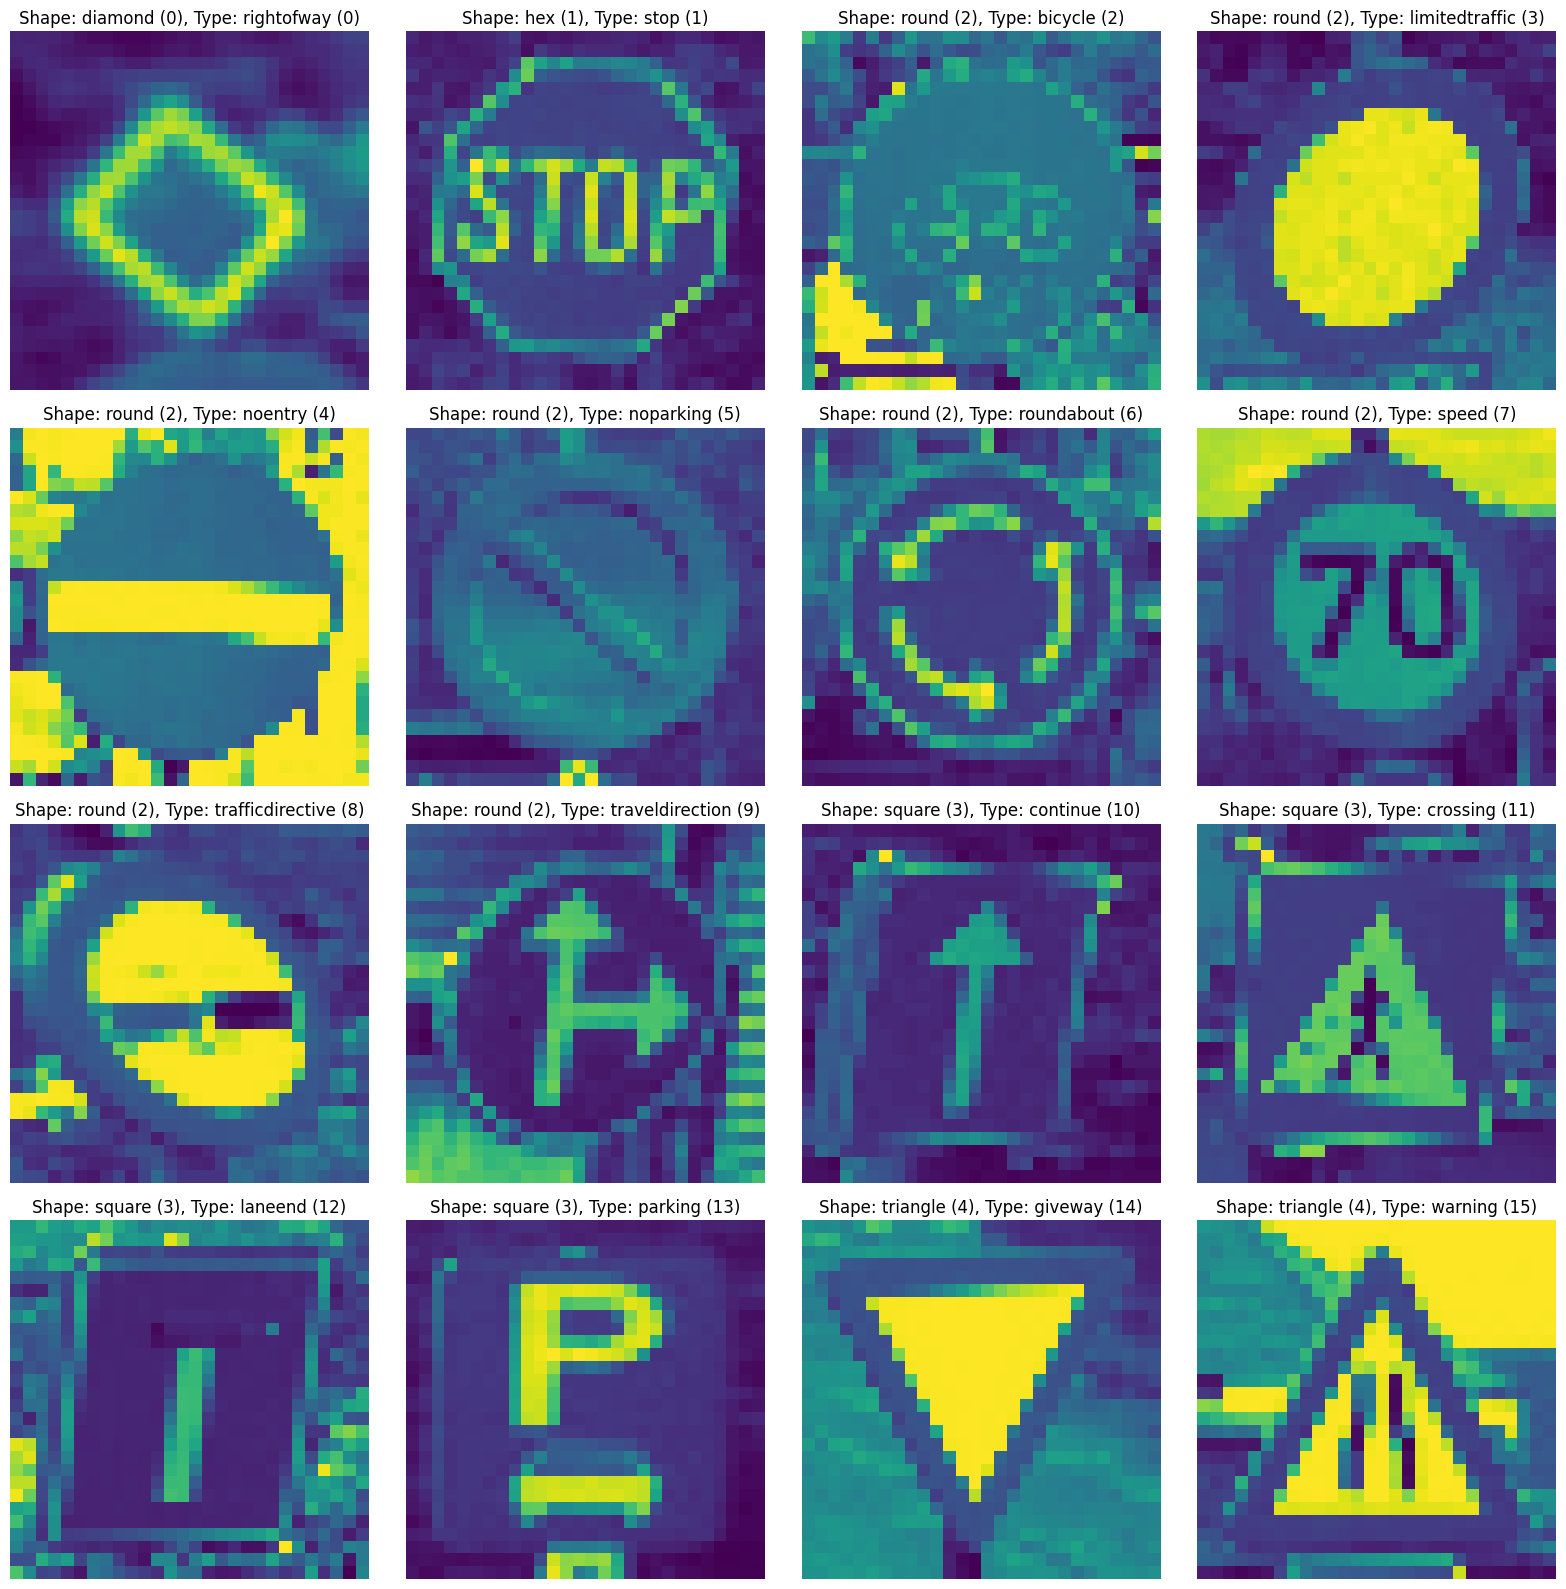

In [14]:
from matplotlib.pyplot import imread
import imageio

# # Now you have 'shape_label' and 'type_label' as separate columns
# # We'll concatenate these labels to create a unique identifier for each class combination


df['class_combo'] = df[['shape_label', 'type_label']].apply(tuple, axis=1)

# Reverse dictionaries to map labels back to names
shape_names = {v: k for k, v in trafficsigns_shapes.items()}
type_names = {v: k for k, v in trafficsigns_types.items()}

# Group by this new combo and pick the first image from each group
grouped = df.groupby('class_combo').first().reset_index()

# Visualization
plt.figure(figsize=(16, 16))
for i, row in enumerate(grouped.itertuples(), 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on the number of unique class combinations
    image_path = os.path.join(os.getcwd(), row.image_path)
    image = imread(image_path)
    # Look up the shape and type names using the reverse dictionaries
    shape_name = shape_names.get(row.shape_label, "Unknown")
    type_name = type_names.get(row.type_label, "Unknown")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Shape: {shape_name} ({row.shape_label}), Type: {type_name} ({row.type_label})", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Distribution of the dataset

<ipython-input-15-2dc661fc10c5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
<ipython-input-15-2dc661fc10c5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(type_labels, rotation=45, ha='right')


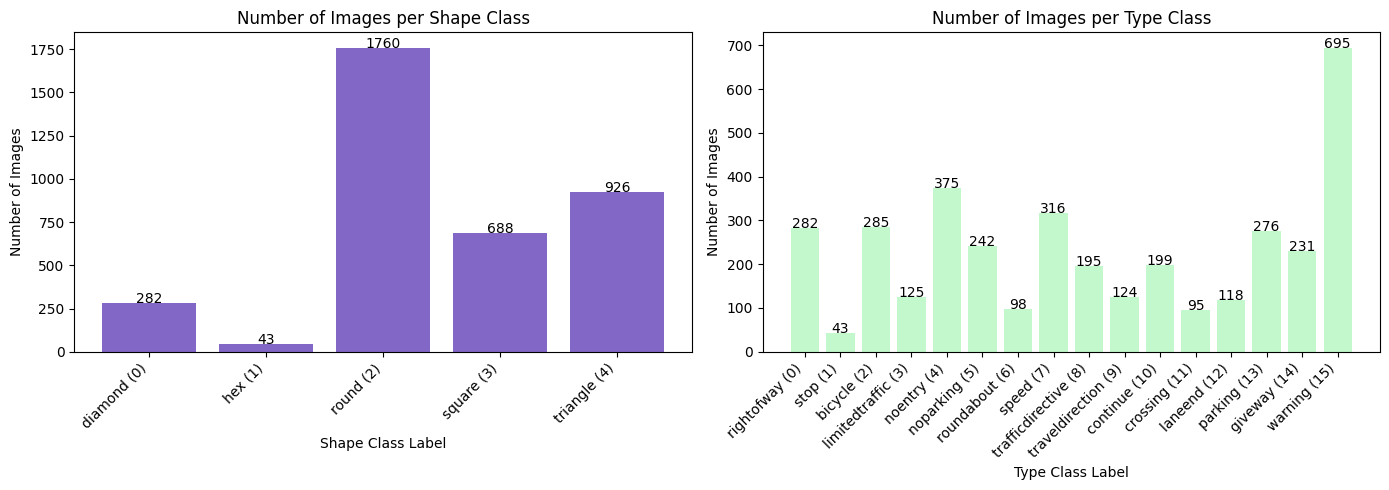

In [15]:
import matplotlib.pyplot as plt


# Convert index to label name for shapes
shape_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_shapes.items(), key=lambda item: item[1])]
# Convert index to label name for types
type_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_types.items(), key=lambda item: item[1])]

# Calculate the count of each class label for shape and type
shape_counts = df['shape_label'].value_counts().sort_index()
type_counts = df['type_label'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Bar chart for shape labels
axes[0].bar(shape_labels, shape_counts.values, color='#8367c7')
axes[0].set_title('Number of Images per Shape Class')
axes[0].set_xlabel('Shape Class Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
for index, value in enumerate(shape_counts.values):
    axes[0].text(index, value, str(value), ha='center')

# Bar chart for type labels
axes[1].bar(type_labels, type_counts.values, color='#C2F8CB')
axes[1].set_title('Number of Images per Type Class')
axes[1].set_xlabel('Type Class Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(type_labels, rotation=45, ha='right')
for index, value in enumerate(type_counts.values):
    axes[1].text(index, value, str(value), ha='center')

plt.tight_layout()
plt.show()



#### Observations:
- Class imbalance: may affect the model performance. Further actions need to do to solve it

## 4. Data Spliting
- split offered dataset into 2 parts.
- Training set: 80%
- Validation set: 20%
- Testing set: the additional dataset

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
test_data = df_test

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 2959, Val Data: 740, Test Data: 2234


In [17]:
train_data.shape

(2959, 4)

In [18]:
# Print column names to verify
print(train_data.columns)


Index(['image_path', 'shape_label', 'type_label', 'class_combo'], dtype='object')


Define a function to plot accuracy between validation data and train data

In [19]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')


## 5.1 Base Model - MLP Neural Network (for 2 tasks)




* **What is an MLP?**
  - A type of neural network with three or more layers: input, hidden, and output layers.
  - Fully connected: Each neuron in one layer connects to every neuron in the next layer.
  - Utilizes backpropagation for learning, adjusting weights to minimize output error.
* **Why choose an MLP as a baseline model?**
  - Simplicity: Easy to implement and requires less setup time.
  - Efficiency: Quick to train, providing fast initial results.
  - Low Resource Use: Less computationally intensive than more complex models.
  - Performance Benchmarking: Provides a reference point for evaluating more advanced models.
  - Data Requirements: Performs well with smaller datasets, ideal when large data is unavailable.
  - Interpretability: Simple architecture makes it easier to understand and deb

**Constants**

In [20]:
# height = 28 pixel, width = 28 pixel
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM_SHAPE = 128
HIDDEN_LAYER_DIM_TYPE = 256
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

#### Install Keras

To build an image classifier we make use of Tensorflow‘ s Keras API to build our model

In [21]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

#### Set up the layers
We will use the Sequential API to build models as it is the simplest. In a **Sequential** type, each layer takes the output from the previous layer and uses it as its input.
**Dense** layers in a neural network mean that every node in one layer is connected to all the nodes in the previous layer.

In [22]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 21.3 MB/s eta 0:00:00


### **Model1.1 Baseline Model --- Traffic sign shape**

In [23]:
model_shape_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_SHAPE, activation='relu', name='m1_shape_hidden1'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_shape_hidden2'),
    tf.keras.layers.Dense(units=16, activation='relu', name='m1_shape_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_SHAPE, activation='softmax', name='m1_shape_output')
])

model_shape_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])

In [24]:
model_shape_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 m1_shape_hidden1 (Dense)    (None, 128)               301184    
                                                                 
 m1_shape_hidden2 (Dense)    (None, 64)                8256      
                                                                 
 m1_shape_hidden3 (Dense)    (None, 16)                1040      
                                                                 
 m1_shape_output (Dense)     (None, 5)                 85        
                                                                 
Total params: 310565 (1.18 MB)
Trainable params: 310565 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


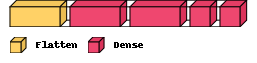

In [25]:
import visualkeras
# Generating the image for model architecture
visualkeras.layered_view(model_shape_1, scale_xy=2, scale_z=1, max_z=50, legend=True)


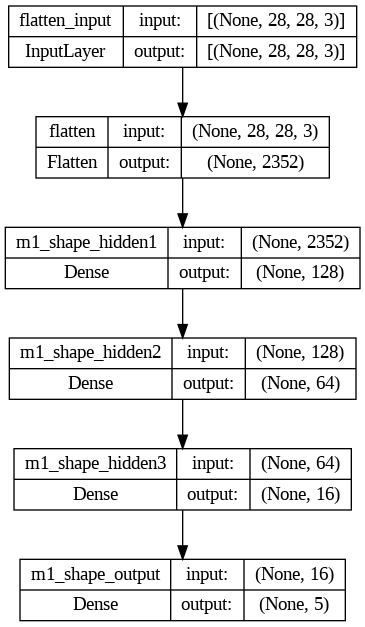

In [26]:
tf.keras.utils.plot_model(model_shape_1, show_shapes=True)


#### Train the base model for shape
- convert the class into string

In [27]:
train_data['shape_label_str'] = train_data['shape_label'].astype('str')
val_data['shape_label_str'] = val_data['shape_label'].astype('str')

train_data['type_label_str'] = train_data['type_label'].astype('str')
val_data['type_label_str'] = val_data['type_label'].astype('str')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32 # increase it to reduce the graph noise

train_generator_shape = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_shape = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


train the base model for shape

In [29]:
%%time
history_1_shape = model_shape_1.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=50, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


CPU times: user 1min 17s, sys: 7.4 s, total: 1min 25s
Wall time: 1min 29s


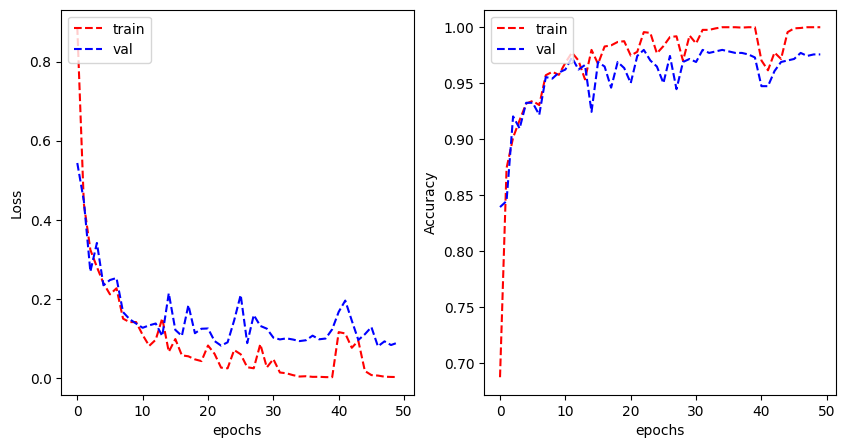

In [30]:
plot_learning_curve(history_1_shape.history['loss'], history_1_shape.history['val_loss'],
                    history_1_shape.history['categorical_accuracy'], history_1_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Function to plot **Confusion Matrix**

In [31]:
def plot_confusion_matrix(model, test_image_generator, y_set, nr_classes, label_names):
  filenames = test_image_generator.filenames
  nb_samples = len(filenames)

  predictions = np.argmax(model.predict(test_image_generator, steps = nb_samples), axis=1)
  f1score = f1_score(y_set, predictions, average='weighted')
  print(f"F1 Score: {f1score:.2f}")
  accuracy = np.mean(predictions == y_set) * 100
  print(f"Accuracy: {accuracy:.2f}%")
  conf_matrix = confusion_matrix(y_set, predictions)

  nr_rows = conf_matrix.shape[0]
  nr_cols = conf_matrix.shape[1]
  plt.figure(figsize=(7,7), dpi=150)
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)

  plt.title('Confusion Matrix', fontsize=16)
  plt.ylabel('Actual Labels', fontsize=12)
  plt.xlabel('Predicted Labels', fontsize=12)

  tick_marks = np.arange(nr_classes)
  plt.yticks(tick_marks, label_names)
  plt.xticks(tick_marks, label_names, rotation=45, ha='right')

  plt.colorbar()

  for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

  plt.show()


### use test data plot confusion matrix

In [32]:
test_data['shape_label_str'] = test_data['shape_label'].astype('str')

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator_shape = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=1,
        shuffle = False,   # ********* this part is very important for testing
        class_mode='categorical')





Found 2234 validated image filenames belonging to 5 classes.


In [34]:
model_shape_1.evaluate(test_generator_shape)

2234/2234 [==============================] - 7s 3ms/step - loss: 0.1734 - categorical_accuracy: 0.9611


[0.17339149117469788, 0.9610564112663269]

2234/2234 [==============================] - 7s 3ms/step
F1 Score: 0.96
Accuracy: 96.11%


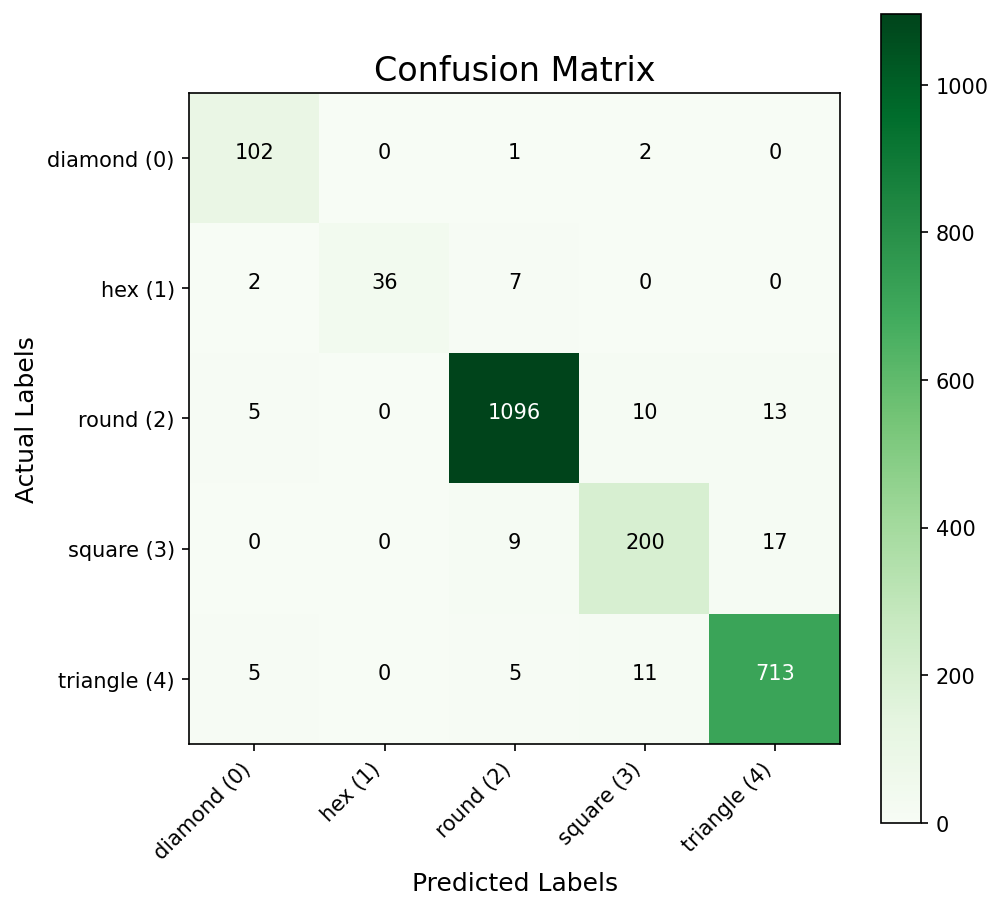

In [35]:
plot_confusion_matrix(model_shape_1, test_generator_shape, test_data['shape_label'], OUTPUT_CLASSES_SHAPE, shape_labels)

### **Model1.2 Baseline Model --- traffic sign type**

In [36]:
model_type_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_TYPE, activation='relu', name='m1_type_hidden1'),
    tf.keras.layers.Dense(units=128, activation='relu', name='m1_type_hidden2'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_type_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_TYPE, activation='softmax', name='m1_output')
])

model_type_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])

In [37]:
model_type_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 m1_type_hidden1 (Dense)     (None, 256)               602368    
                                                                 
 m1_type_hidden2 (Dense)     (None, 128)               32896     
                                                                 
 m1_type_hidden3 (Dense)     (None, 64)                8256      
                                                                 
 m1_output (Dense)           (None, 16)                1040      
                                                                 
Total params: 644560 (2.46 MB)
Trainable params: 644560 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


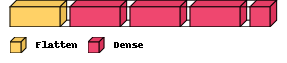

In [38]:
# Generating the image for model architecture
visualkeras.layered_view(model_type_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

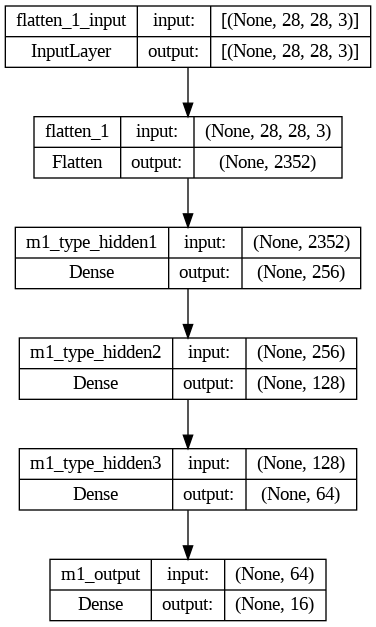

In [39]:
tf.keras.utils.plot_model(model_type_1, show_shapes=True)

In [40]:

#'image_path', 'shape_label', 'type_label'
train_generator_type = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="type_label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_type = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="type_label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

TypeError: If class_mode="categorical", y_col="type_label" column values must be type string, list or tuple.

### train the base model (type)

In [ ]:
# %%time
history_type = model_type_1.fit(train_generator_type, validation_data = validation_generator_type, epochs=50, verbose=0)

In [ ]:
plot_learning_curve(history_type.history['loss'], history_type.history['val_loss'],
                    history_type.history['categorical_accuracy'], history_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

**Findings**
- the accuracy is too high. That may be because that the current dataset only has 3699 samples in total


## Data Augmentation
- Data augmentation can apply to images dataset to increase the size of whole dataset (by using transaction, rotations, zomming etc.)


The ImageDataGenerator module in Keras enhances dataset diversity through transformations such as shifts, zoom, shear, and rotation. This augmentation improves model robustness and reduces overfitting by simulating real-world variations.

In [41]:
# Define augmentation parameters

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

Apply the data augmentation into train and validation dataset

In [42]:
train_generator_shape_aug = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_shape_aug = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [79]:
train_generator_type_aug = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="type_label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_type_aug = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="type_label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

TypeError: If class_mode="categorical", y_col="type_label" column values must be type string, list or tuple.

#### Test the data with created models

In [44]:
# %%time
history_1_shape_augment = model_shape_1.fit_generator(train_generator_shape_aug, validation_data = validation_generator_shape_aug, epochs=50, verbose=0)

<ipython-input-44-69d1d7ca801d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1_shape_augment = model_shape_1.fit_generator(train_generator_shape_aug, validation_data = validation_generator_shape_aug, epochs=50, verbose=0)


KeyboardInterrupt: 

In [ ]:
plot_learning_curve(history_1_shape_augment.history['loss'], history_1_shape_augment.history['val_loss'],
                    history_1_shape_augment.history['categorical_accuracy'], history_1_shape_augment.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [ ]:
# %%time
history_1_type_augment = model_type_1.fit_generator(train_generator_type_aug, validation_data = validation_generator_type_aug, epochs=50, verbose=0)

In [ ]:
plot_learning_curve(history_1_type_augment.history['loss'], history_1_type_augment.history['val_loss'],
                    history_1_type_augment.history['categorical_accuracy'], history_1_type_augment.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Fetch an original image from the dataset
# original_images, _ = next(train_generator)  # Reset to get the first image consistently
# original_image = original_images[0]

# # Create separate generators for each specific augmentation to control and demonstrate each one
# augmentations = {
#     'Rotation (40°)': ImageDataGenerator(rotation_range=40),
#     'Width Shift (20%)': ImageDataGenerator(width_shift_range=0.2),
#     'Height Shift (20%)': ImageDataGenerator(height_shift_range=0.2),
#     'Shear (20%)': ImageDataGenerator(shear_range=0.2),
#     'Zoom (20%)': ImageDataGenerator(zoom_range=0.2),
#     'Horizontal Flip': ImageDataGenerator(horizontal_flip=True)
# }

# # Display the original image and each augmentation
# fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(20, 3))
# axes = axes.flatten()

# # Show the original image first
# axes[0].imshow(original_image)
# axes[0].axis('off')
# axes[0].set_title('Original Image')

# # Apply each augmentation and display the result
# for i, (desc, gen) in enumerate(augmentations.items(), start=1):
#     # Generate augmented image
#     # Must expand dimension of original_image to fit the generator input requirement
#     aug_image = gen.flow(np.expand_dims(original_image, 0), batch_size=1).next()[0]
#     axes[i].imshow(aug_image)
#     axes[i].axis('off')
#     axes[i].set_title(desc)

# plt.tight_layout()
# plt.show()

# Model1.3 Combined Model using MLP NN

This model is designed to take a 28x28 RGB image as input and predict two attributes of traffic signs simultaneously: their shape (among 5 categories) and type (among 16 categories). It utilizes shared layers for feature extraction and diverges into two separate paths for different classification tasks, enabling efficient learning of distinct yet related outputs.

In [45]:
# height = 28 pixel, width = 28 pixel
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [46]:
import visualkeras
model = tf.keras.Sequential([
    # Flatten the input to a 1D array
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Dense layer with 256 neurons using sigmoid activation
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    # Add a dropout layer for regularization
    tf.keras.layers.Dropout(0.5),
    # Since we need two outputs, we can't directly use a single dense layer as the output layer.
    # We need a way to split the network here into two paths, each tailored to our class sizes.
    # For this, we will expand the model beyond the Sequential model capabilities.
])

# Adding two separate output layers
shape_output = tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax', name='shape_output')(model.output)
type_output = tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax', name='type_output')(model.output)

# Creating a new model that includes both outputs
final_model = tf.keras.Model(inputs=model.input, outputs=[shape_output, type_output])

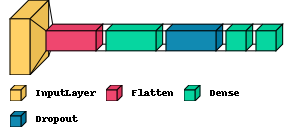

In [47]:
# Generating the image for model architecture
visualkeras.layered_view(final_model, scale_xy=2, scale_z=1, max_z=50, legend=True)


* The initial layer in this network, **tf.keras.layers.Flatten**, converts the images from a two-dimensional array (28 by 28 pixels) into a one-dimensional array, totaling 2352 pixels (28 * 28 * 3)
* Following the flattening process, the network employs a **tf.keras.layers.Dense layer**, which contains 256 neurons and utilises sigmoid activation. This fully connected layer is capable of learning intricate patterns from the flattened input data.
* To enhance the model's generalisation capabilities and prevent overfitting, a **tf.keras.layers.Dropout** is incorporated next, setting approximately 50% of the neuron outputs to zero during training at random.
* **Multi-output model**:
the model diverges from a traditional sequential setup to accommodate dual outputs for classifying image data into multiple categories. At the end of the network:
  - Shape Output: A dense layer with softmax activation predicts among 5 shape classes.
  - Type Output: Another dense layer with softmax activation predicts among 16 type classes.

* The final structure, final_model, integrates these outputs into one framework, enabling simultaneous prediction of both shape and type of traffic signs from single images.

In [48]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 flatten_2_input (InputLaye  [(None, 28, 28, 3)]          0         []                            
 r)                                                                                               
                                                                                                  
 flatten_2 (Flatten)         (None, 2352)                 0         ['flatten_2_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 128)                  301184    ['flatten_2[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 128)                  0         ['dense[0][0]']           

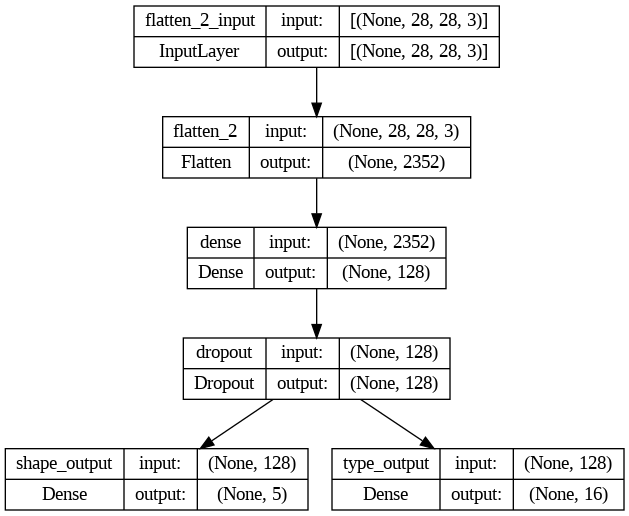

In [49]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

### Compile the model

In [50]:
# Compile the model
final_model.compile(optimizer='adam',
                    loss={'shape_output': 'sparse_categorical_crossentropy',
                          'type_output': 'sparse_categorical_crossentropy'},
                    metrics=['accuracy'])

- We use ‘Adam’ optimiser because it is very efficient and needs low-memory (fast speed).
- **sparse_categorical_crossentropy:** we use this loss function because our class labels for both shape and type are provided as integers (e.g., [0, 1, 2, 3, 4] for shapes and [0, 1, ..., 15] for types). It is used when the classes are encoded as integers, which is more memory efficient, especially for scenarios where the number of classes is quite large.

### Train the model

Convert labels to be in string format for ImageDataGenerator

In [51]:
# Apply the 'assign_class_label' function to assign shape and type labels
train_data['Shape'], train_data['Type'] = zip(*train_data['image_path'].apply(assign_class_label))
val_data['Shape'], val_data['Type'] = zip(*val_data['image_path'].apply(assign_class_label))

# Convert classes to strings if not already
train_data['Shape'] = train_data['Shape'].astype('str')
train_data['Type'] = train_data['Type'].astype('str')
val_data['Shape'] = val_data['Shape'].astype('str')
val_data['Type'] = val_data['Type'].astype('str')

In [52]:
from sklearn.preprocessing import LabelEncoder

# Encode Shape and Type labels
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

train_data['Shape'] = shape_encoder.fit_transform(train_data['Shape'])
val_data['Shape'] = shape_encoder.transform(val_data['Shape'])

train_data['Type'] = type_encoder.fit_transform(train_data['Type'])
val_data['Type'] = type_encoder.transform(val_data['Type'])


In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# Modify generators to handle two types of labels
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col=["Shape", "Type"],  # Two columns for y_col
        target_size=(28, 28),  # Ensure target size matches the input size of the network
        batch_size=batch_size,
        class_mode='multi_output')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col=["Shape", "Type"],  # Two columns for y_col
        target_size=(28, 28),  # Ensure target size matches the input size of the network
        batch_size=batch_size,
        class_mode='multi_output')

Found 2959 validated image filenames.
Found 740 validated image filenames.


In [ ]:
# Reference for data augmentation

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Data generators
# # Training generator with image augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,        # Random rotations from 0 to 40 degrees
#     width_shift_range=0.2,    # Random horizontal shifts up to 20% of the image width
#     height_shift_range=0.2,   # Random vertical shifts up to 20% of the image height
#     shear_range=0.2,          # Shear transformation
#     zoom_range=0.2,           # Random zoom up to 20%
#     horizontal_flip=True,     # Random horizontal flips
#     fill_mode='nearest',      # Strategy for filling in newly created pixels
#     data_format='channels_last'
# )

# # Validation generator without augmentation, only rescaling
# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     data_format='channels_last'
# )

# batch_size = 32

# # Modify generators to handle two types of labels
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Two columns for y_col
#         target_size=(28, 28),  # Ensure target size matches the input size of the network
#         batch_size=batch_size,
#         class_mode='multi_output')

# validation_generator = val_datagen.flow_from_dataframe(
#         dataframe=val_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Two columns for y_col
#         target_size=(28, 28),  # Ensure target size matches the input size of the network
#         batch_size=batch_size,
#         class_mode='multi_output')


In [55]:
# Ensure to use 'final_model' for training with the correct input and output layers
history = final_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=0
)

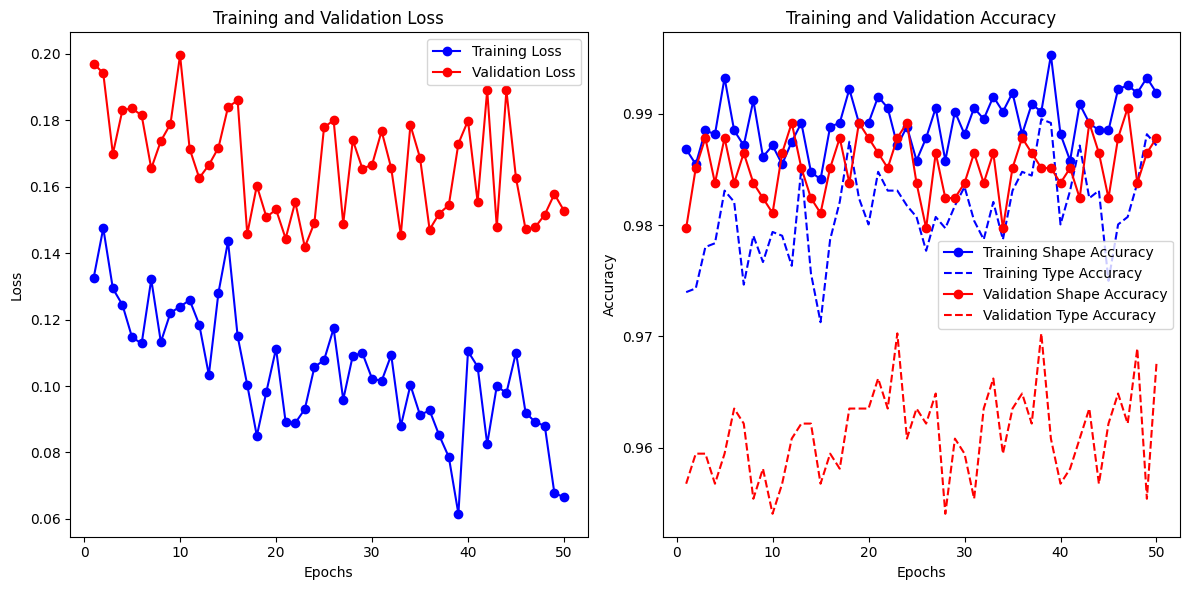

In [56]:
def plot_learning_curve_for_combined(loss, val_loss, shape_acc, type_acc, val_shape_acc, val_type_acc):
    import matplotlib.pyplot as plt
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, shape_acc, 'bo-', label='Training Shape Accuracy')
    plt.plot(epochs, type_acc, 'b--', label='Training Type Accuracy')
    plt.plot(epochs, val_shape_acc, 'ro-', label='Validation Shape Accuracy')
    plt.plot(epochs, val_type_acc, 'r--', label='Validation Type Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Now use the function with correct keys
plot_learning_curve_for_combined(history.history['loss'], history.history['val_loss'],
                    history.history['shape_output_accuracy'], history.history['type_output_accuracy'],
                    history.history['val_shape_output_accuracy'], history.history['val_type_output_accuracy'])


*Observation*
- As the model trains through more epochs, we see a decrease in loss and an increase in accuracy. This means the model is effectively learning from the training data and getting better at correctly classifying the traffic signs into their respective shapes and types. The graphs show that both the training and validation losses drop significantly as the model trains, and the accuracy for identifying shapes and types increases. The training accuracy is slightly higher than the validation accuracy, but since they're close and follow a similar trend, it doesn't indicate serious overfitting. This small gap between the training and validation results is normal and shows that the model is learning well and can handle new, unseen data effectively.




In [57]:
print(history.history.keys())

dict_keys(['loss', 'shape_output_loss', 'type_output_loss', 'shape_output_accuracy', 'type_output_accuracy', 'val_loss', 'val_shape_output_loss', 'val_type_output_loss', 'val_shape_output_accuracy', 'val_type_output_accuracy'])


In [58]:
# Average training accuracy
avg_training_accuracy = sum(history.history['shape_output_accuracy']) / len(history.history['shape_output_accuracy'])

# Average validation accuracy
avg_validation_accuracy = sum(history.history['val_shape_output_accuracy']) / len(history.history['val_shape_output_accuracy'])

print(f"Average Shape Training Accuracy: {avg_training_accuracy*100:.2f}%")
print(f"Average Shape Validation Accuracy: {avg_validation_accuracy*100:.2f}%")



Average Shape Training Accuracy: 98.92%
Average Shape Validation Accuracy: 98.52%


In [59]:
# Average training accuracy for Type output
avg_training_accuracy_type = sum(history.history['type_output_accuracy']) / len(history.history['type_output_accuracy'])

# Average validation accuracy for Type output
avg_validation_accuracy_type = sum(history.history['val_type_output_accuracy']) / len(history.history['val_type_output_accuracy'])

print(f"Average Type Training Accuracy: {avg_training_accuracy_type*100:.2f}%")
print(f"Average Type Validation Accuracy: {avg_validation_accuracy_type*100:.2f}%")

Average Type Training Accuracy: 98.11%
Average Type Validation Accuracy: 96.12%


In [60]:
print(history.history.keys())


dict_keys(['loss', 'shape_output_loss', 'type_output_loss', 'shape_output_accuracy', 'type_output_accuracy', 'val_loss', 'val_shape_output_loss', 'val_type_output_loss', 'val_shape_output_accuracy', 'val_type_output_accuracy'])


In [61]:
# Assuming 'history' is the variable holding the training history
# Replace 'shape_output_accuracy' and 'val_shape_output_accuracy' with your actual metric names if they are different

# Maximum training accuracy
max_training_accuracy = max(history.history['shape_output_accuracy'])  # or 'type_output_accuracy' as applicable
max_training_epoch = history.history['shape_output_accuracy'].index(max_training_accuracy)

# Maximum validation accuracy
max_validation_accuracy = max(history.history['val_shape_output_accuracy'])  # or 'val_type_output_accuracy' as applicable
max_validation_epoch = history.history['val_shape_output_accuracy'].index(max_validation_accuracy)

print(f"Maximum Training Accuracy: {max_training_accuracy*100:.2f}% at epoch {max_training_epoch+1}")
print(f"Maximum Validation Accuracy: {max_validation_accuracy*100:.2f}% at epoch {max_validation_epoch+1}")


Maximum Training Accuracy: 99.53% at epoch 39
Maximum Validation Accuracy: 99.05% at epoch 47


In [62]:
# Assuming 'history' is the variable holding the training history
# Replace 'type_output_accuracy' and 'val_type_output_accuracy' with your actual metric names if they are different

# Maximum training accuracy for Type
max_type_training_accuracy = max(history.history['type_output_accuracy'])  # Use the correct key for type accuracy
max_type_training_epoch = history.history['type_output_accuracy'].index(max_type_training_accuracy)

# Maximum validation accuracy for Type
max_type_validation_accuracy = max(history.history['val_type_output_accuracy'])  # Use the correct key for type validation accuracy
max_type_validation_epoch = history.history['val_type_output_accuracy'].index(max_type_validation_accuracy)

print(f"Maximum Training Type Accuracy: {max_type_training_accuracy*100:.2f}% at epoch {max_type_training_epoch+1}")
print(f"Maximum Validation Type Accuracy: {max_type_validation_accuracy*100:.2f}% at epoch {max_type_validation_epoch+1}")


Maximum Training Type Accuracy: 98.95% at epoch 38
Maximum Validation Type Accuracy: 97.03% at epoch 23


### Incremental changes

In [ ]:
# Drop-out?


The evaluation results show that the model performs well in predicting shapes with an accuracy of 97.16%. However, its accuracy in predicting types is notably lower at 7.43%. This indicates a need for improvement in the model's ability to predict types accurately.

## Ploting some results

# 5.2 Advanced Model: CNN model


CNNs are better suited for tasks like image recognition because they can exploit the spatial structure of the data through convolutional layers, reducing the number of parameters needed compared to fully connected layers in MLPs, making them more efficient and effective for tasks with spatial relationships, like images.



# VGG

The VGG architecture enhances basic CNNs through:
1. Uniformity: It consistently uses 3×3 convolutional filters and 2×2 max pooling, facilitating deeper network construction.
2. Depth: Deeper layers in VGG allow for more complex feature learning, improving image classification performance.
3. Robust Training: Strong initialisation, regularisation, and augmentation strategies improve training and prevent overfitting.



Observations:


Visually Interpreting the CNN's Inner Layers

We examine the internal layers of the CNN model to gain insights and interpret the significance of the features that the model identified while classifying a traffic sign

Display prediction result

show green color when correct & red when incorrect Actual Vs Predicted

### Model 2.1 Shape classification using VGG CNN


In [81]:
# height = 28 pixel, width = 28 pixel
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [82]:
import tensorflow as tf
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

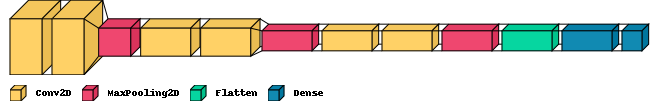

In [83]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

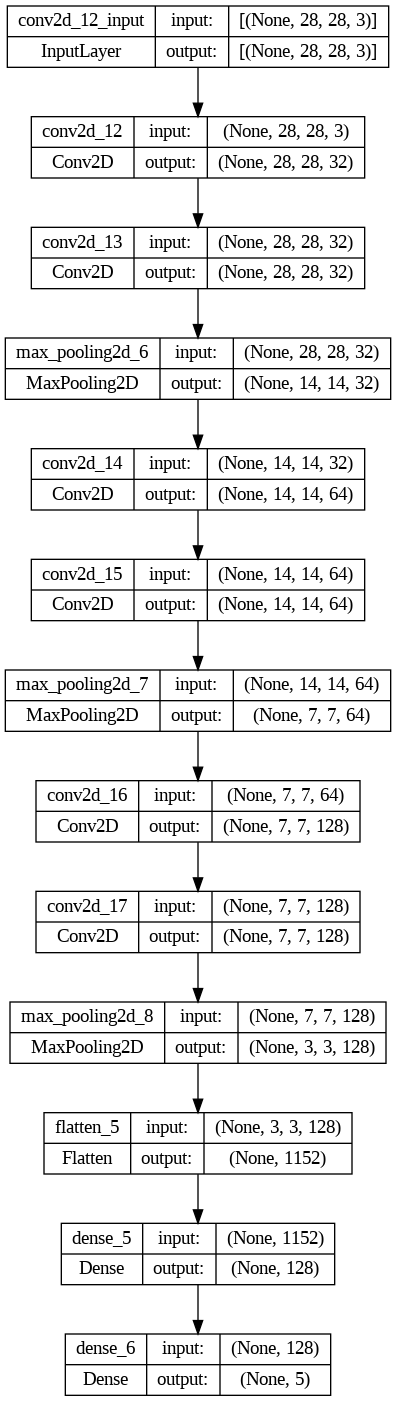

In [84]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

In [85]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1000
#'image_path', 'shape_label', 'type_label'
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [87]:
history_VGG_1 = model_VGG_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    verbose=0
)

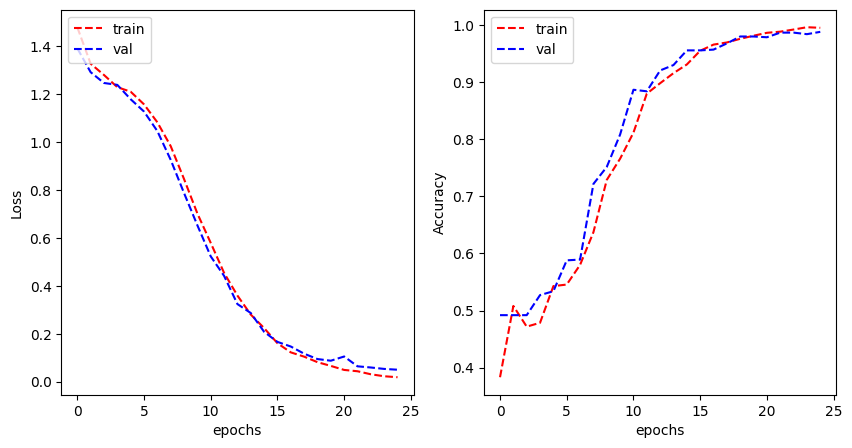

In [88]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [89]:
# Assuming history_VGG_1.history['categorical_accuracy'] and
# history_VGG_1.history['val_categorical_accuracy'] are for shape classification:
shape_train_accuracies = history_VGG_1.history['categorical_accuracy']
shape_val_accuracies = history_VGG_1.history['val_categorical_accuracy']

# Calculate maximum and average accuracies for shape classification
max_shape_train_accuracy = max(shape_train_accuracies) * 100  # Convert to percentage
max_shape_train_epoch = shape_train_accuracies.index(max(shape_train_accuracies)) + 1  # Get epoch number (+1 for 1-based index)

average_shape_train_accuracy = (sum(shape_train_accuracies) / len(shape_train_accuracies)) * 100  # Convert to percentage

max_shape_val_accuracy = max(shape_val_accuracies) * 100  # Convert to percentage
max_shape_val_epoch = shape_val_accuracies.index(max(shape_val_accuracies)) + 1  # Get epoch number (+1 for 1-based index)

average_shape_val_accuracy = (sum(shape_val_accuracies) / len(shape_val_accuracies)) * 100  # Convert to percentage

print("Maximum Training Accuracy for Shape Classification: {:.2f}% at Epoch {}".format(max_shape_train_accuracy, max_shape_train_epoch))
print("Average Training Accuracy for Shape Classification: {:.2f}%".format(average_shape_train_accuracy))
print("Maximum Validation Accuracy for Shape Classification: {:.2f}% at Epoch {}".format(max_shape_val_accuracy, max_shape_val_epoch))
print("Average Validation Accuracy for Shape Classification: {:.2f}%".format(average_shape_val_accuracy))

Maximum Training Accuracy for Shape Classification: 99.59% at Epoch 24
Average Training Accuracy for Shape Classification: 79.52%
Maximum Validation Accuracy for Shape Classification: 98.78% at Epoch 25
Average Validation Accuracy for Shape Classification: 81.33%


Optimize learning rate

### Model 2.2 Type classification using VGG CNN


In [90]:
import tensorflow as tf


model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE),
])

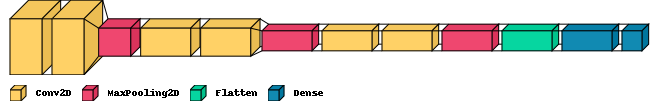

In [91]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

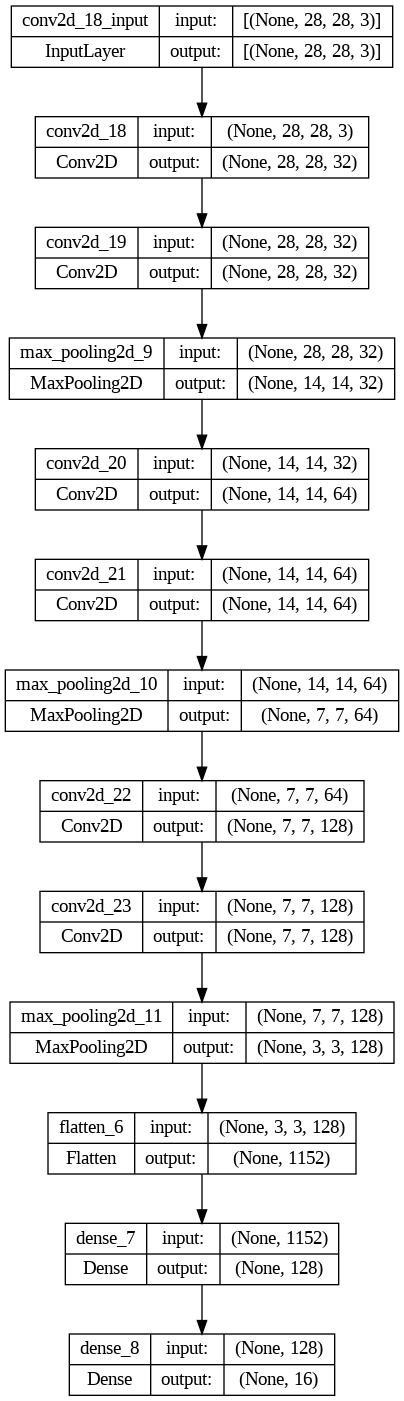

In [92]:
tf.keras.utils.plot_model(model_VGG_2, show_shapes=True)

In [93]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1000
#'image_path', 'shape_label', 'type_label'
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="type_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="type_label_str",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [96]:
history_VGG_2 = model_VGG_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    verbose=0
)

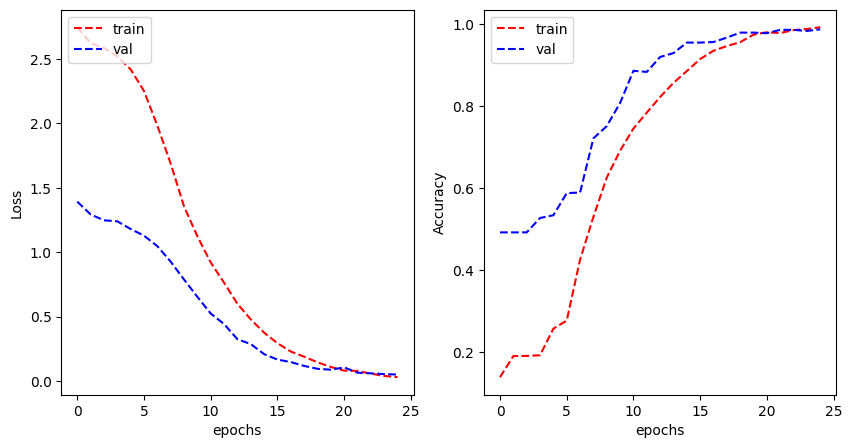

In [97]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_2.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [98]:
# Assuming history_VGG_2.history['categorical_accuracy'] and
# history_VGG_2.history['val_categorical_accuracy'] are for type classification:
type_train_accuracies = history_VGG_2.history['categorical_accuracy']
type_val_accuracies = history_VGG_2.history['val_categorical_accuracy']

# Calculate maximum and average accuracies for type classification
max_type_train_accuracy = max(type_train_accuracies) * 100  # Convert to percentage
max_type_train_epoch = type_train_accuracies.index(max(type_train_accuracies)) + 1  # Get epoch number (+1 for 1-based index)
average_type_train_accuracy = (sum(type_train_accuracies) / len(type_train_accuracies)) * 100  # Convert to percentage

max_type_val_accuracy = max(type_val_accuracies) * 100  # Convert to percentage
max_type_val_epoch = type_val_accuracies.index(max(type_val_accuracies)) + 1  # Get epoch number (+1 for 1-based index)
average_type_val_accuracy = (sum(type_val_accuracies) / len(type_val_accuracies)) * 100  # Convert to percentage

print("Maximum Training Accuracy for Type Classification: {:.2f}% at Epoch {}".format(max_type_train_accuracy, max_type_train_epoch))
print("Average Training Accuracy for Type Classification: {:.2f}%".format(average_type_train_accuracy))
print("Maximum Validation Accuracy for Type Classification: {:.2f}% at Epoch {}".format(max_type_val_accuracy, max_type_val_epoch))
print("Average Validation Accuracy for Type Classification: {:.2f}%".format(average_type_val_accuracy))

Maximum Training Accuracy for Type Classification: 99.29% at Epoch 25
Average Training Accuracy for Type Classification: 69.07%
Maximum Validation Accuracy for Type Classification: 96.08% at Epoch 23
Average Validation Accuracy for Type Classification: 69.62%


## 6. Testing the final model

In [ ]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(32, 32),
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

In [ ]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 32  # or any batch size that fits your memory constraints

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(28, 28),  # Ensure target size matches the input size of the network
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

# # Evaluate the model
# final_model.evaluate(test_generator)


In [ ]:
# ## still wrong

# import matplotlib.pyplot as plt
# import numpy as np

# # Increase the figure size and font size for better visibility
# plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 12}  # Increase font size for better readability
# plt.rc('font', **font)

# batches = 0
# for x, y in test_generator:
#     batches += 1
#     y_hat = final_model.predict(x, verbose=0)
#     x = np.squeeze(x)
#     if batches < 5:
#         plt.subplot(1, 5, batches)
#         plt.imshow(x[0])  # Displaying the first image in the batch
#         shape_pred_index = np.argmax(y[0])
#         type_pred_index = np.argmax(y_hat[1])
#         try:
#             shape_label = shapes_inv[shape_pred_index]
#         except KeyError:
#             shape_label = 'Unknown Shape'
#         try:
#             type_label = types_inv[type_pred_index]
#         except KeyError:
#             type_label = 'Unknown Type'
#         plt.title("Actual-{}, Pred-{}".format(shape_label, type_label), pad=20)  # Add padding to avoid overlap
#     else:
#         break

#     plt.axis('off')
# plt.tight_layout()  # Adjust layout to fit everything nicely
# plt.show()


## 7. Conclusion


MLPs serve as a practical baseline for tasks like traffic sign classification due to their straightforward implementation and quick training. They are capable of modelling interactions between all input features, which is crucial for recognising complex patterns in the dataset. However, they are typically less effective than Convolutional Neural Networks (CNNs) for processing image data, as CNNs excel at capturing spatial hierarchies through their convolutional layers. This is evident from comparison tables where CNNs consistently show lower loss and higher accuracy.
In conclusion, we think Model 2 (CNN) is superior.


# 8. References

- https://www.linkedin.com/pulse/classify-traffic-signs-deep-learning-james-medel/
- https://github.com/james94/P3-Traffic-Sign-Classifier-CarND/blob/master/Traffic_Sign_Classifier_with_LeNet.ipynb
- https://www.youtube.com/watch?v=jztwpsIzEGc
- https://www.datacamp.com/tutorial/cnn-tensorflow-python